In [21]:
# Google Drive Connection
from google.colab import drive
drive.mount('/content/drive')

!ls '/content/drive/My Drive/fake-or-not/data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
dataset		     dataset_correct_ManTraNet.csv
dataset_correct.csv  output_vggnet16_cnn.csv


In [0]:
import os
import re
import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from sklearn import metrics
import itertools

%config InlineBackend.figure_format = 'retina'
pd.set_option('display.max_colwidth', 300)

In [0]:
def get_file_names(path):
    '''
    Get image name from the address of the image. 
    Eg: If './drive/My Drive/Data/dataset/6lhnml_fake.jpg' is input, out is '6lgmdn_true.jpg'
    '''
    pattern = re.compile("(.*)(\/)(.+\..+$)")
    image_names = []
    for p in path:
        image_name = pattern.search(p)
        image_name = image_name.group(3)
        image_names.append(image_name)
    return image_names


In [0]:
fake_pattern = re.compile(".+_fake\.jpg$")
true_pattern = re.compile(".+_true\.jpg$")

def get_y_true(name):
    if fake_pattern.search(name):
        return 1
    elif true_pattern.search(name):
        return 0
    else:
        return -1
    pass

In [25]:
# load ela and cnn model
path = '/content/drive/My Drive/fake-or-not/Result/output_ELA_CNN.csv'
ela_cnn = pd.read_csv(path)
print(ela_cnn.shape)
ela_cnn.head()

(3177, 4)


,Unnamed: 0,path,label_0,label_1
0,18005,D:/ML final project/PS_Battles/dataset/6lhnml_fake.jpg,0.838113,0.164561
1,18006,D:/ML final project/PS_Battles/dataset/6lhnml_true.jpg,0.528719,0.470627
2,18007,D:/ML final project/PS_Battles/dataset/6lijxs_fake.jpg,0.420581,0.581143
3,18008,D:/ML final project/PS_Battles/dataset/6lijxs_true.jpg,0.804305,0.196666
4,18009,D:/ML final project/PS_Battles/dataset/6lm7is_fake.jpg,0.272515,0.731217


In [26]:
ela_cnn = ela_cnn[['path', 'label_1']]
ela_cnn.columns = ['path', 'y_pred_ela_cnn']
ela_cnn.path = get_file_names(ela_cnn.path)
ela_cnn.head()

,path,y_pred_ela_cnn
0,6lhnml_fake.jpg,0.164561
1,6lhnml_true.jpg,0.470627
2,6lijxs_fake.jpg,0.581143
3,6lijxs_true.jpg,0.196666
4,6lm7is_fake.jpg,0.731217


In [27]:
y_true_ela_cnn = ela_cnn["path"].apply(lambda name: get_y_true(name))
y_pred_class_ela_cnn = [1 if p>0.5 else 0 for p in ela_cnn.y_pred_ela_cnn]
print('Accuracy of ELA and CNN = {}'.format(metrics.accuracy_score(y_true_ela_cnn, y_pred_class_ela_cnn)))

Accuracy of ELA and CNN = 0.7119924457034938


In [28]:
# load vggnet16 model
path = '/content/drive/My Drive/fake-or-not/Result/output_vggnet16.csv'
vgg = pd.read_csv(path)
print(vgg.shape)
vgg.head()

(3178, 4)


,Unnamed: 0,path,label_0,label_1
0,0,D:/ML final project/PS_Battles/dataset/6lgmdn_true.jpg,0.605837,0.394163
1,1,D:/ML final project/PS_Battles/dataset/6lhnml_fake.jpg,0.636619,0.363381
2,2,D:/ML final project/PS_Battles/dataset/6lhnml_true.jpg,0.666594,0.333406
3,3,D:/ML final project/PS_Battles/dataset/6lijxs_fake.jpg,0.690418,0.309582
4,4,D:/ML final project/PS_Battles/dataset/6lijxs_true.jpg,0.517439,0.482561


In [29]:
vgg = vgg[['path', 'label_1']]
vgg.columns = ['path', 'y_pred_vgg']
vgg.path = get_file_names(vgg.path)
vgg.head()

,path,y_pred_vgg
0,6lgmdn_true.jpg,0.394163
1,6lhnml_fake.jpg,0.363381
2,6lhnml_true.jpg,0.333406
3,6lijxs_fake.jpg,0.309582
4,6lijxs_true.jpg,0.482561


In [30]:
# load mantranet model
path = '/content/drive/My Drive/fake-or-not/Result/output_ManTraNet_CNN.csv'
mantra = pd.read_csv(path)
print(mantra.shape)
mantra.head()

(3178, 4)


,Unnamed: 0,path,label_0,label_1
0,0,./drive/My Drive/Data/dataset/6lgmdn_true.jpg,0.646303,0.353698
1,1,./drive/My Drive/Data/dataset/6lhnml_fake.jpg,0.443669,0.562953
2,2,./drive/My Drive/Data/dataset/6lhnml_true.jpg,0.430099,0.581129
3,3,./drive/My Drive/Data/dataset/6lijxs_fake.jpg,0.399021,0.602312
4,4,./drive/My Drive/Data/dataset/6lijxs_true.jpg,0.435568,0.565544


In [31]:
y_true_mantra = mantra["path"].apply(lambda name: get_y_true(name))
y_pred_class_mantra = [1 if p>0.5 else 0 for p in mantra.label_1]
print('Accuracy of ManTra-Net and CNN = {}'.format(metrics.accuracy_score(y_true_mantra, y_pred_class_mantra)))

Accuracy of ManTra-Net and CNN = 0.5774071743234739


In [32]:
mantra = mantra[['path', 'label_1']]
mantra.columns = ['path', 'y_pred_mantra']
mantra.path = get_file_names(mantra.path)
mantra.head()

,path,y_pred_mantra
0,6lgmdn_true.jpg,0.353698
1,6lhnml_fake.jpg,0.562953
2,6lhnml_true.jpg,0.581129
3,6lijxs_fake.jpg,0.602312
4,6lijxs_true.jpg,0.565544


In [33]:
# merge
merge_1 = ela_cnn.merge(mantra, how='inner', on='path')
print(merge_1.shape)
merge_1.head()

(3177, 3)


,path,y_pred_ela_cnn,y_pred_mantra
0,6lhnml_fake.jpg,0.164561,0.562953
1,6lhnml_true.jpg,0.470627,0.581129
2,6lijxs_fake.jpg,0.581143,0.602312
3,6lijxs_true.jpg,0.196666,0.565544
4,6lm7is_fake.jpg,0.731217,0.542390


In [34]:
merge_2 = merge_1.merge(vgg, how='inner', on='path')
print(merge_2.shape)
merge_2.head()

(3177, 4)


,path,y_pred_ela_cnn,y_pred_mantra,y_pred_vgg
0,6lhnml_fake.jpg,0.164561,0.562953,0.363381
1,6lhnml_true.jpg,0.470627,0.581129,0.333406
2,6lijxs_fake.jpg,0.581143,0.602312,0.309582
3,6lijxs_true.jpg,0.196666,0.565544,0.482561
4,6lm7is_fake.jpg,0.731217,0.542390,0.483960


In [0]:
def get_true_labels(path):
    fake = re.compile(".+_fake\.jpg$")
    true = re.compile(".+_true\.jpg$")
    y_true = []
    for p in path:
        if(fake.search(p)):
            y_true.append(1)
        elif(true.search(p)):
            y_true.append(0)
        else:
            y_true.append(-1)
    
    return y_true

y_true = get_true_labels(merge_2.path)

In [0]:
ela_cnn_y_pred = merge_2.y_pred_ela_cnn
vgg_y_pred = merge_2.y_pred_vgg
mantra_y_pred = merge_2.y_pred_mantra

In [0]:
# create model validation functions
def plot_confusion_matrix(y_true, y_pred, normalize=False):
    """
    Input:
        y_true    : array of true binary labels. Eg: [0, 1, 0, 0, 1].
        y_pred    : array of predicted probabilities. Eg: [0.05, 0.55, 0.2, 0.8, 0.95].
        normalize : whether to show counts of proportion in a cell
    
    Output:
        confusion matrix
    """
    cm = metrics.confusion_matrix(y_true, y_pred)
    
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    #plt.colorbar()
    classes = np.unique(y_true)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if(normalize):
        precision=4
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], precision)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    pass


def plot_roc_curve(y_true, y_pred_1, y_pred_2, y_pred_3):
    """
    Input:
        y_true    : array of true binary labels. Eg: [0, 1, 0, 0, 1].
        y_pred_i  : array of probability scores from ith model. Eg: [0.12, 0.43, 0.26, 0.67, 0.49].
    Output:
        ROC curve
    """
    
    # no skill: predict majority class
    major_class = np.argmax(np.bincount(y_true))
    pred        = [major_class for _ in range(len(y_true))]
    auc         = metrics.roc_auc_score(y_true, pred)
    fpr, tpr, _ = metrics.roc_curve(y_true, pred)
    plt.plot(fpr, tpr, '--', color='black', label='Chance (AUC = {:.1f})'.format(auc))
    
    # ela and cnn model
    auc         = metrics.roc_auc_score(y_true, y_pred_1)
    fpr, tpr, _ = metrics.roc_curve(y_true, y_pred_1)
    plt.plot(fpr, tpr, color='red', label='ELA and CNN (AUC = {:.3f})'.format(auc))

    # vgg16 model
    auc         = metrics.roc_auc_score(y_true, y_pred_2)
    fpr, tpr, _ = metrics.roc_curve(y_true, y_pred_2)
    plt.plot(fpr, tpr, color='blue', label='VGG16 (AUC = {:.3f})'.format(auc))

    # mantranet and cnn model
    auc         = metrics.roc_auc_score(y_true, y_pred_3)
    fpr, tpr, _ = metrics.roc_curve(y_true, y_pred_3)
    plt.plot(fpr, tpr, color='green', label='ManTra-Net (AUC = {:.3f})'.format(auc))

    # axis labels
    plt.xlabel('False Positive Rate', fontsize=17)
    plt.ylabel('True Positive Rate', fontsize=17)
    plt.grid('on')
    plt.axis('square')
    plt.legend(prop={"size":12})
    plt.tight_layout()
    plt.title('ROC Curve', fontsize=19)
    pass

def plot_pr_curve(y_true, y_pred_1, y_pred_2, y_pred_3):
    """
    Input:
        y_true    : array of true binary labels. Eg: [0, 1, 0, 0, 1].
        y_pred_i  : array of probability scores from ith model. Eg: [0.12, 0.43, 0.26, 0.67, 0.49].
    Output:
        Precision-recall curve
    """

    # no skill: predict majority class
    major_class = np.argmax(np.bincount(y_true))
    pred        = [major_class for _ in range(len(y_true))]
    p, r, _     = metrics.precision_recall_curve(y_true, pred, pos_label=1)
    plt.plot(p, r, '--', color='grey', label='Chance')

    # ela and cnn model
    p, r, _ = metrics.precision_recall_curve(y_true, y_pred_1, pos_label=1)
    plt.plot(p, r, color='red', label='ELA and CNN')

    # vgg16 model
    p, r, _ = metrics.precision_recall_curve(y_true, y_pred_2, pos_label=1)
    plt.plot(p, r, color='blue', label='VGG16')

    # mantranet and cnn model
    p, r, _ = metrics.precision_recall_curve(y_true, y_pred_3, pos_label=1)
    plt.plot(p, r, color='green', label='ManTra-Net')

    # plot aesthetics
    plt.xlim([0, 1])
    plt.legend(prop={"size":12})
    plt.xlabel('Recall', fontsize=17)
    plt.ylabel('Precision', fontsize=17)
    plt.grid('on')
    plt.tight_layout()
    plt.title('Precision-Recall Curve', fontsize=19)
    pass


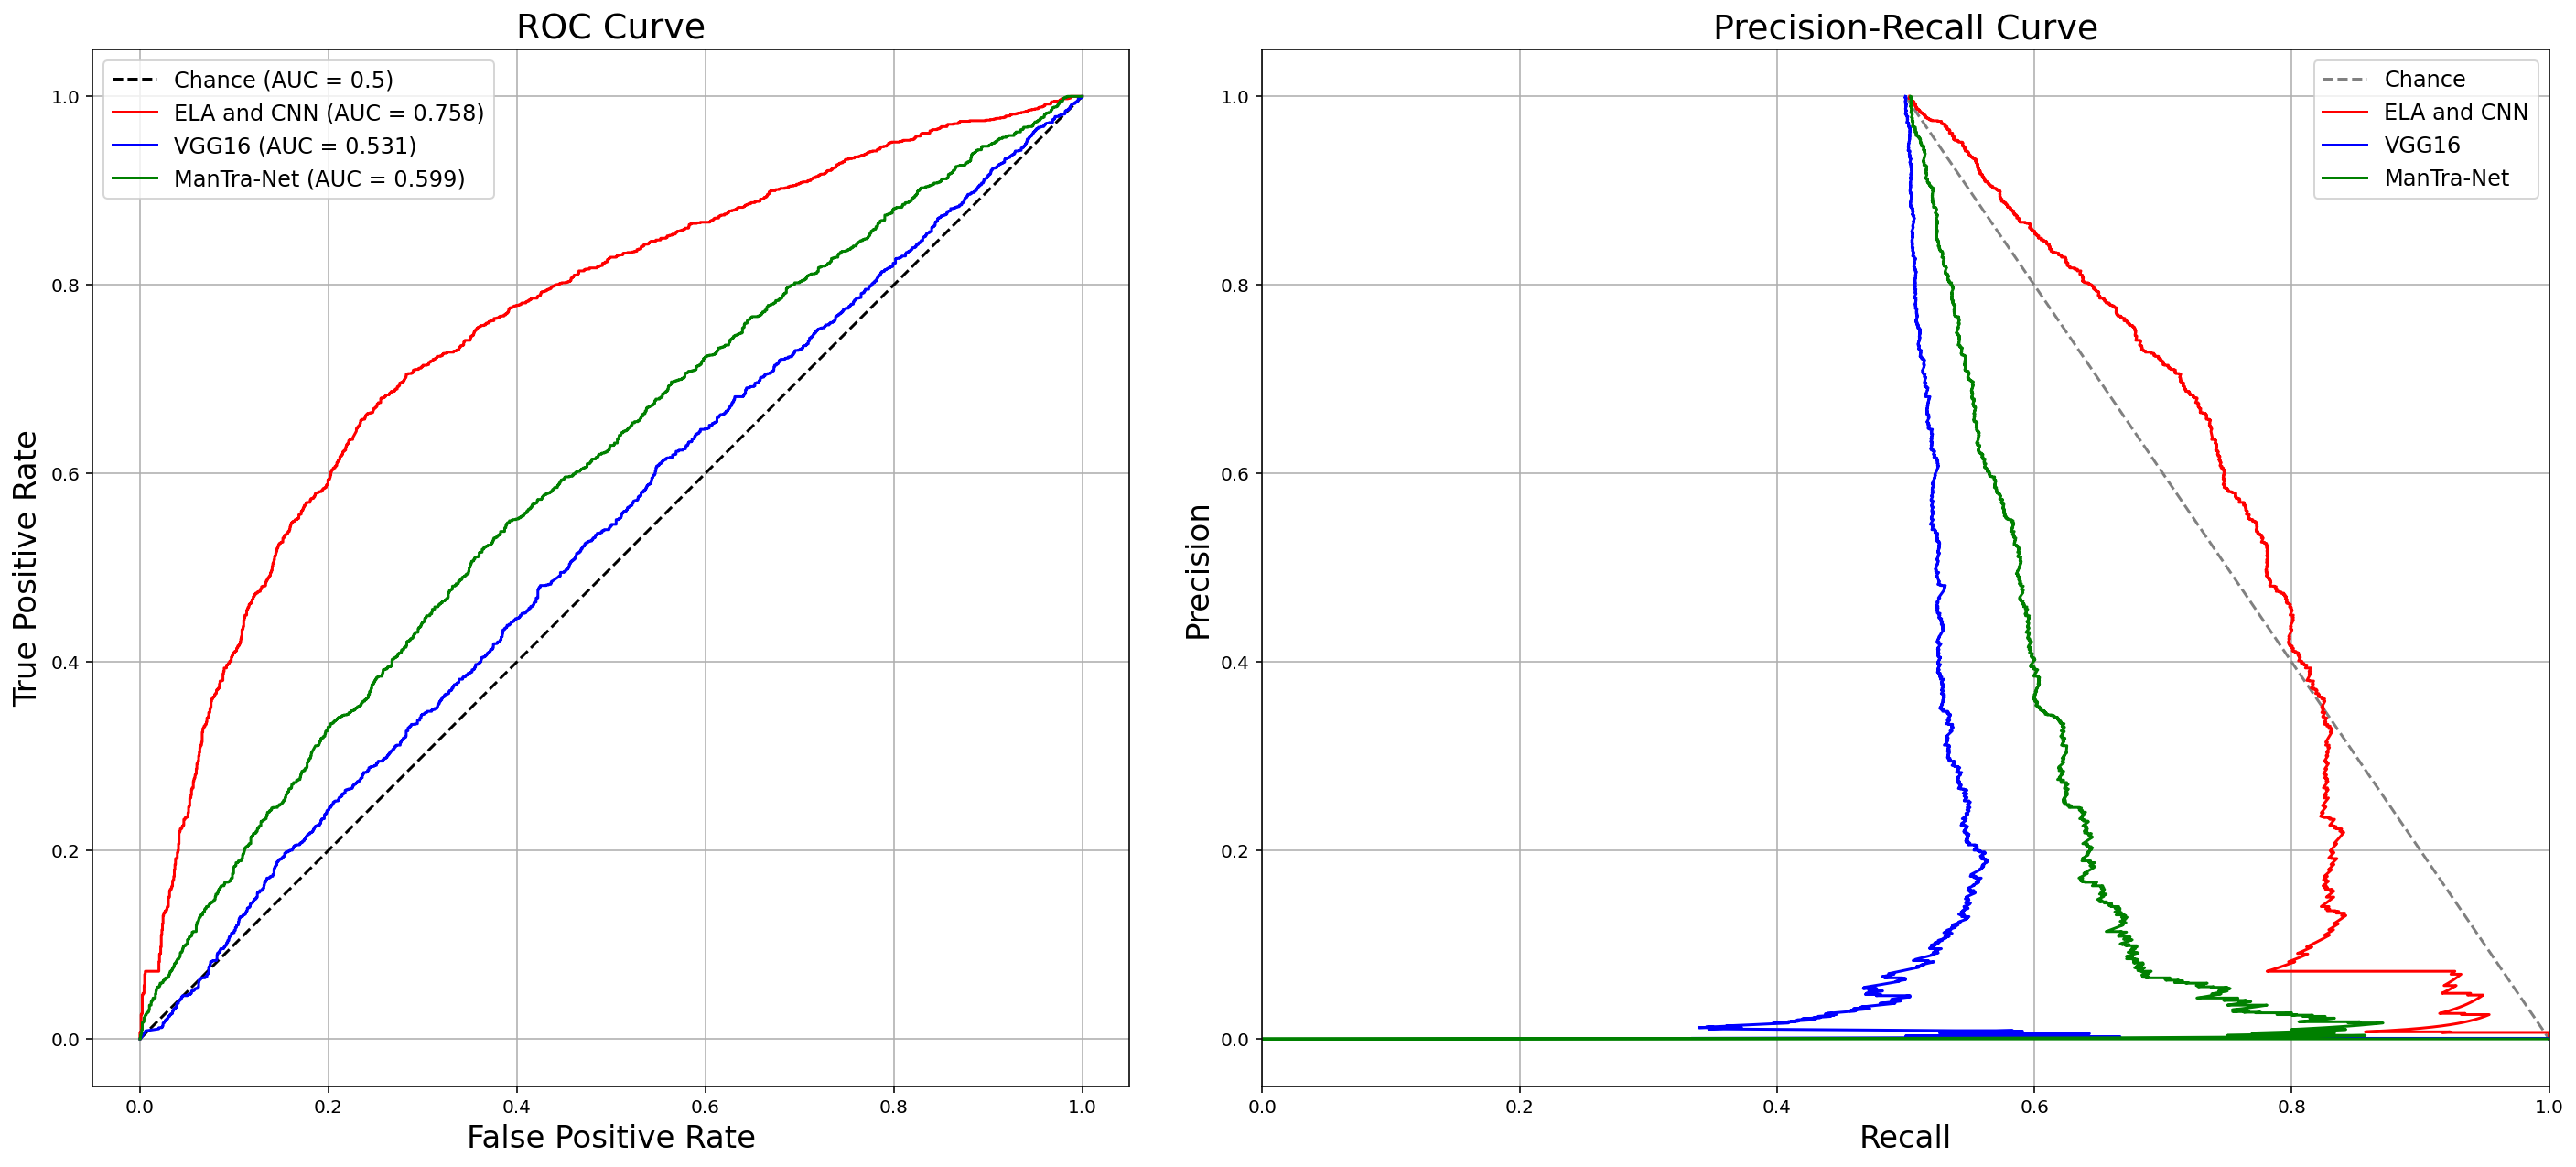

In [60]:
plt.figure(figsize=(20, 9))

# plot ROC-AUC curve
plt.subplot(1, 2, 1)
plot_roc_curve(y_true, ela_cnn_y_pred, vgg_y_pred, mantra_y_pred)

# plot precision-recall curve
plt.subplot(1, 2, 2)
plot_pr_curve(y_true, ela_cnn_y_pred, vgg_y_pred, mantra_y_pred)